In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Предобработка данных

### Чтение данных и перевод столбцов в PEP8

In [ ]:
data = pd.read_csv('ecom_yl.csv')
data.columns = data.columns.str.lower().str.replace(' ', '_')
data.head()

(1012, 15)

### Количество изначальных пропусков

In [ ]:
cols = data.columns
for col in cols:
  missing_count = pd.isna(data[col]).sum().item()
  print(f'{col} - {missing_count} пропусков')

user_id - 0 пропусков
region - 13 пропусков
device - 13 пропусков
channel - 13 пропусков
session_start - 0 пропусков
session_end - 0 пропусков
sessiondurationsec - 0 пропусков
session_date - 0 пропусков
month - 0 пропусков
day - 0 пропусков
hour_of_day - 0 пропусков
order_dt - 727 пропусков
revenue - 727 пропусков
payment_type - 727 пропусков
promo_code - 727 пропусков


### Исправление лексикографических ошибок

In [ ]:
data['region'] = data['region'].replace(['Frаnce', 'Frаncе', 'Franсe'], 'France')
data['region'] = data['region'].replace('Unjted States', 'United States')
data['region'] = data['region'].replace('UК', 'UK')
data['region'] = data['region'].replace('germany', 'Germany')
data['device'] = data['device'].replace('android', 'Android')
data['channel'] = data['channel'].replace('контексная реклама', 'контекстная реклама')

### Заполнение пропусков пользователей, которые уже заходили

In [ ]:
data['region'] = data.groupby('user_id')['region'].transform(lambda x: x.fillna(x.iloc[0]))
data['device'] = data.groupby('user_id')['device'].transform(lambda x: x.fillna(x.iloc[0]))
data['channel'] = data.groupby('user_id')['channel'].transform(lambda x: x.fillna(x.iloc[0]))

### Удаление идентичных дубликатов

In [ ]:
data.drop_duplicates(keep='first', inplace=True)

(1009, 15)

### Удалили пользователя без данных

### Убрали странный промокод

In [ ]:
data = data.drop(data[data['user_id'] == 16254498222].index)

In [ ]:
data['promo_code'] = data['promo_code'].apply(lambda x: 0 if 0 < x < 1 else x)
data['sessiondurationsec'] = data['sessiondurationsec'].apply(lambda x: round(x))

### Перевод типа данных необходимых столбцов в datetime

In [ ]:
data['session_start'] = pd.to_datetime(data['session_start'])
data['session_end'] = pd.to_datetime(data['session_end'])
data['session_date'] = pd.to_datetime(data['session_date'])
data['order_dt'] = pd.to_datetime(data['order_dt'])

### Проанализировать выбросы и заменить их

In [ ]:
lower_bound = data['revenue'].quantile(0.01)
upper_bound = data['revenue'].quantile(0.98)
m = data['revenue'].median()
data.loc[(data['revenue'] < lower_bound) | (data['revenue'] > upper_bound), 'revenue'] = m

### Весь ли период исследовать?

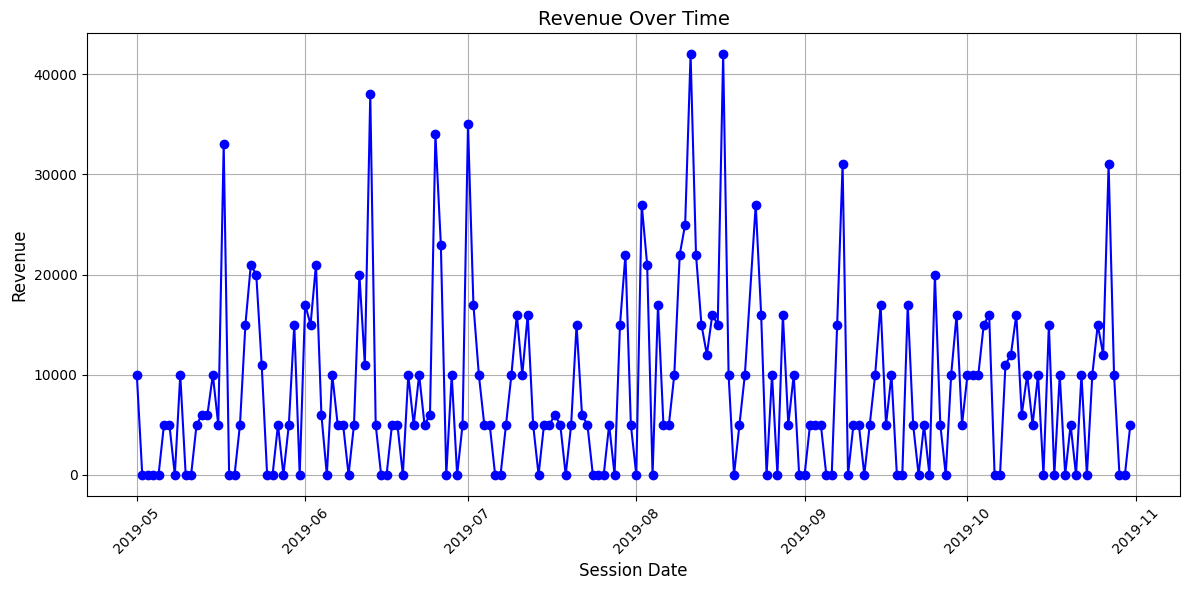

In [ ]:
df_plot = data.groupby('session_date')['revenue'].sum().reset_index()
plt.figure(figsize=(12, 6))
plt.plot(df_plot['session_date'], df_plot['revenue'], marker='o', linestyle='-', color='b')
plt.title('Revenue Over Time', fontsize=14)
plt.xlabel('Session Date', fontsize=12)
plt.ylabel('Revenue', fontsize=12)
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Столбец итоговой суммы с промокодом

In [ ]:
data['revenue'] = data['revenue'].fillna(0)
data['total_revenue'] = data.apply(
    lambda row: row['revenue'] * 0.9 if row['promo_code'] == 1 else row['revenue'],
    axis=1
)
data['total_revenue'] = data['total_revenue'].fillna(0)

### Добавить столбец с указанием времени суток визита "time_of_day"

In [ ]:
data['time_of_day'] = data['hour_of_day'].apply(
    lambda x: 'утро' if (x >= 6) and (x < 10) else ('день' if (x >= 10) and (x < 17) else ('вечер' if (x >= 17) and (x < 22) else 'ночь'))
)

### Добавить столбец с указанием, является ли человек платящим "payer"

In [ ]:
data['payer'] = data.apply(
    lambda x: 1 if (x['total_revenue'] > 0) else 0, axis =1)
data.head(20)

,user_id,region,device,channel,session_start,session_end,sessiondurationsec,session_date,month,day,hour_of_day,order_dt,revenue,payment_type,promo_code,total_revenue,time_of_day,payer
0,529697267522,United States,iPhone,социальные сети,2019-05-01 00:06:40,2019-05-01 00:07:06,26,2019-05-01,5,3,0,2019-05-01 00:06:40,9999.0,Mobile payments,0.0,9999.0,ночь,1
1,601292388085,United States,PC,organic,2019-05-01 06:56:16,2019-05-01 07:09:18,782,2019-05-01,5,3,7,NaT,0.0,NaN,NaN,0.0,утро,0
2,852898876338,United States,Mac,социальные сети,2019-05-01 04:30:45,2019-05-01 04:34:56,251,2019-05-01,5,3,4,NaT,0.0,NaN,NaN,0.0,ночь,0
3,998513020664,United States,iPhone,социальные сети,2019-05-01 18:53:42,2019-05-01 18:57:35,233,2019-05-01,5,3,18,NaT,0.0,NaN,NaN,0.0,вечер,0
4,240702200943,United States,Mac,социальные сети,2019-05-02 14:04:32,2019-05-02 14:09:51,319,2019-05-02,5,4,14,NaT,0.0,NaN,NaN,0.0,день,0
5,271758921583,United States,iPhone,социальные сети,2019-05-02 08:40:35,2019-05-02 08:41:15,40,2019-05-02,5,4,8,NaT,0.0,NaN,NaN,0.0,утро,0
6,425357155257,United States,Android,социальные сети,2019-05-02 16:32:29,2019-05-02 16:55:30,1381,2019-05-02,5,4,16,NaT,0.0,NaN,NaN,0.0,день,0
7,768721432035,France,Mac,реклама у блогеров,2019-05-02 10:21:30,2019-05-02 10:51:54,1824,2019-05-02,5,4,10,NaT,0.0,NaN,NaN,0.0,день,0
8,177410811849,United States,Android,социальные сети,2019-05-03 18:43:49,2019-05-03 19:30:52,2823,2019-05-03,5,5,19,NaT,0.0,NaN,NaN,0.0,вечер,0
9,337713702816,United States,iPhone,реклама у блогеров,2019-05-03 19:48:35,2019-05-03 20:16:10,1655,2019-05-03,5,5,20,NaT,0.0,NaN,NaN,0.0,вечер,0


### Вывод

Исправили пропуски:
        12 пропусков в полях region, device, channel:
            Второй заход пользователя
        1 пропуск в полях region, device, channel:
            Пользователь без данных входа - удалили
        727 пропусков, связанных с покупкой:
            Пользователь не купил ничего - игнорировали

Идентичные дубликаты - удалили (4 дубликата)

Баг в системе: значение 0.86 в поле promo_code  -  обнулили (2 промокода)

# Аналитический и графический анализ данных

### Доля продаж по регионам

In [ ]:
total = data['total_revenue'].sum()
revenue_by_region = data.groupby('region')['total_revenue'].agg(['sum', 'median']).reset_index()
revenue_by_region['sum_percentage'] = revenue_by_region['sum'].apply(lambda x: str(round(x* 100/total, 2)) + '%')
print(revenue_by_region, '\n')

          region        sum  median sum_percentage
0         France   134874.8     0.0          8.89%
1        Germany   133275.7     0.0          8.79%
2             UK   186766.6     0.0         12.32%
3  United States  1061609.8     0.0          70.0% 



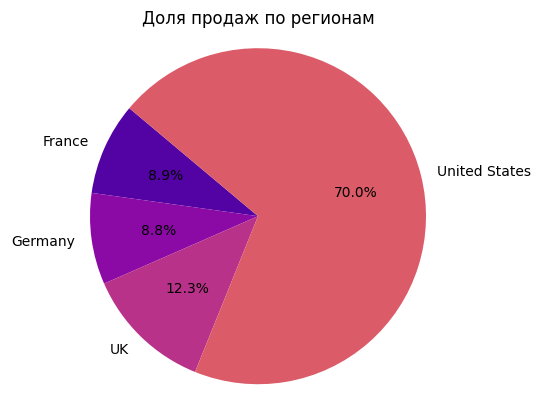

In [ ]:
colors = sns.color_palette("plasma")
revenue_by_region = data.groupby('region')['total_revenue'].sum()
plt.pie(revenue_by_region, labels=revenue_by_region.index, autopct='%1.1f%%', startangle=140, colors=colors)
plt.title('Доля продаж по регионам')
plt.axis('equal')
plt.show()

### Доля продаж по источникам

In [ ]:
revenue_by_channel = data.groupby('channel')['total_revenue'].agg(['sum', 'median']).reset_index()
revenue_by_channel['sum_percentage'] = revenue_by_channel['sum'].apply(lambda x: str(round(x* 100/total, 2)) + '%')
print(revenue_by_channel, '\n')

               channel       sum  median sum_percentage
0       email-рассылки   36493.3     0.0          2.41%
1              organic  475814.8     0.0         31.38%
2  контекстная реклама  230156.6     0.0         15.18%
3   реклама у блогеров  156271.3     0.0          10.3%
4      социальные сети  617790.9     0.0         40.74% 



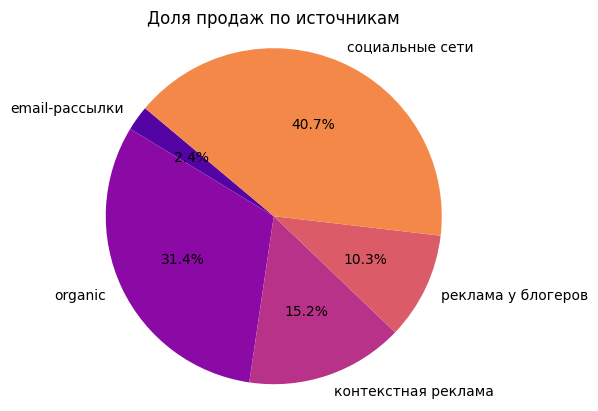

In [ ]:
revenue_by_channel = data.groupby('channel')['total_revenue'].sum()
plt.pie(revenue_by_channel, labels=revenue_by_channel.index, autopct='%1.1f%%', startangle=140, colors=colors)
plt.title('Доля продаж по источникам')
plt.axis('equal')
plt.show()

### Доля продаж по устройствам

In [ ]:
revenue_by_device = data.groupby('device')['total_revenue'].agg(['sum', 'median']).reset_index()
revenue_by_device['sum_percentage'] = revenue_by_device['sum'].apply(lambda x: str(round(x* 100/total, 2)) + '%')
print(revenue_by_device, '\n')

    device       sum  median sum_percentage
0  Android  388429.3     0.0         25.61%
1      Mac  328340.8     0.0         21.65%
2       PC  283149.4     0.0         18.67%
3   iPhone  516607.4     0.0         34.07% 



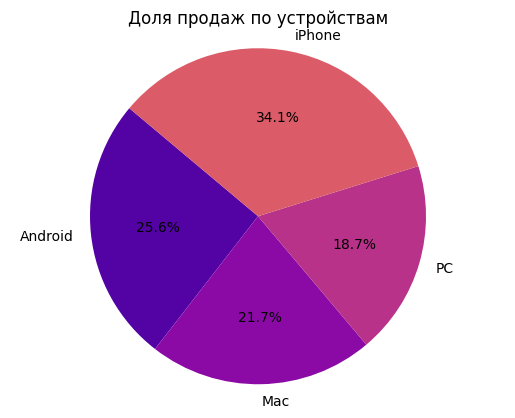

In [ ]:
revenue_by_device = data.groupby('device')['total_revenue'].sum()
plt.pie(revenue_by_device, labels=revenue_by_device.index, autopct='%1.1f%%', startangle=140, colors=colors)
plt.title('Доля продаж по устройствам')
plt.axis('equal')
plt.show()

### Количество пользователей с разбивкой на платящих/не платящих по регионам

In [ ]:
payer_by_region = data.groupby(['region', 'payer'])['payer'].value_counts().reset_index()
print(payer_by_region)

          region  payer  count
0         France      0     78
1         France      1     26
2        Germany      0     78
3        Germany      1     25
4             UK      0     83
5             UK      1     34
6  United States      0    488
7  United States      1    196


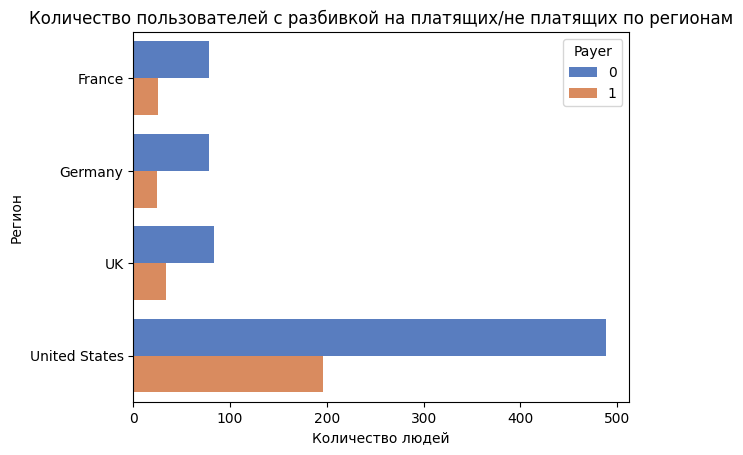

In [ ]:
payer_by_region = data.groupby(['region', 'payer'])['payer'].value_counts().reset_index()
sns.barplot(data=payer_by_region, x='count', y='region', hue='payer', palette='muted')
plt.title('Количество пользователей с разбивкой на платящих/не платящих по регионам')
plt.xlabel('Количество людей')
plt.ylabel('Регион')
plt.legend(title='Payer')
plt.show()

### Количество пользователей с разбивкой на платящих/не платящих по источникам

In [ ]:
payer_by_channel = data.groupby(['channel', 'payer'])['payer'].value_counts().reset_index()
print(payer_by_channel)

               channel  payer  count
0       email-рассылки      0     17
1       email-рассылки      1      7
2              organic      0    259
3              organic      1     88
4  контекстная реклама      0    117
5  контекстная реклама      1     45
6   реклама у блогеров      0     72
7   реклама у блогеров      1     29
8      социальные сети      0    262
9      социальные сети      1    112


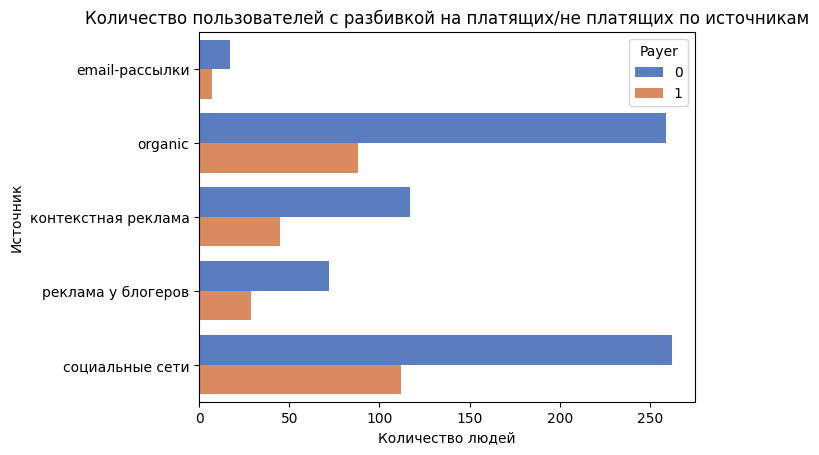

In [ ]:
payer_by_channel = data.groupby(['channel', 'payer'])['payer'].value_counts().reset_index()
sns.barplot(data=payer_by_channel, x='count', y='channel', hue='payer', palette='muted')
plt.title('Количество пользователей с разбивкой на платящих/не платящих по источникам')
plt.xlabel('Количество людей')
plt.ylabel('Источник')
plt.legend(title='Payer')
plt.show()

### Количество пользователей с разбивкой на платящих/не платящих по устройствам

In [ ]:
payer_by_device = data.groupby(['device', 'payer'])['payer'].value_counts().reset_index()
print(payer_by_device)

    device  payer  count
0  Android      0    165
1  Android      1     73
2      Mac      0    146
3      Mac      1     61
4       PC      0    155
5       PC      1     52
6   iPhone      0    261
7   iPhone      1     95


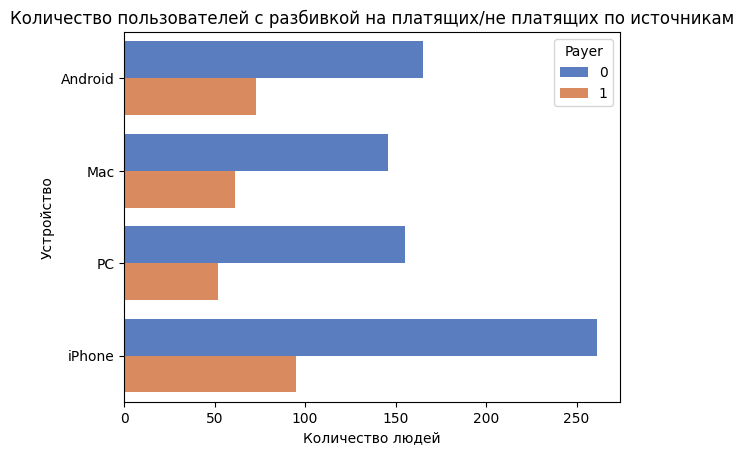

In [ ]:
payer_by_device = data.groupby(['device', 'payer'])['payer'].value_counts().reset_index()
sns.barplot(data=payer_by_device, x='count', y='device', hue='payer', palette='muted')
plt.title('Количество пользователей с разбивкой на платящих/не платящих по источникам')
plt.xlabel('Количество людей')
plt.ylabel('Устройство')
plt.legend(title='Payer')
plt.show()

### Графики, показывающие есть ли сезонность в продажах по месяцам, дням недели, времени суток

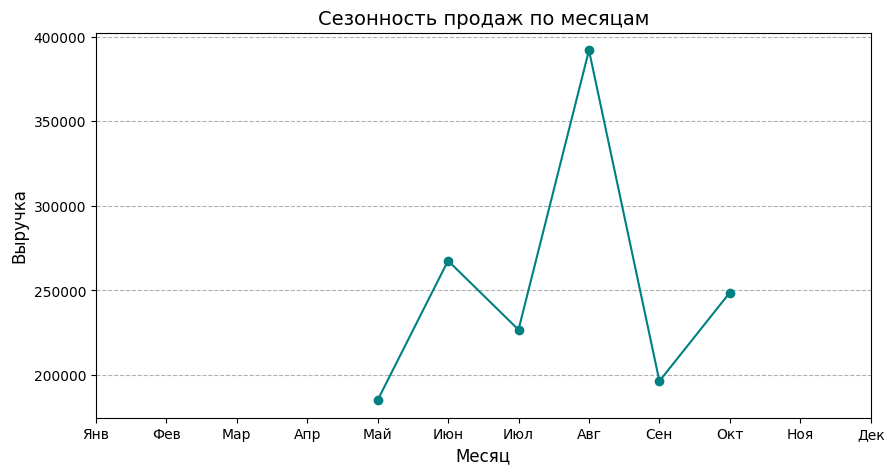

In [ ]:
monthly_revenue = data.groupby('month')['total_revenue'].sum().reset_index()
plt.figure(figsize=(10, 5))
plt.plot(monthly_revenue['month'], monthly_revenue['total_revenue'], marker='o', color='teal')
plt.title('Сезонность продаж по месяцам', fontsize=14)
plt.xlabel('Месяц', fontsize=12)
plt.ylabel('Выручка', fontsize=12)
plt.xticks(range(1, 13), labels=['Янв', 'Фев', 'Мар', 'Апр', 'Май', 'Июн', 'Июл', 'Авг', 'Сен', 'Окт', 'Ноя', 'Дек'])
plt.grid(axis='y', linestyle='--')
plt.show()

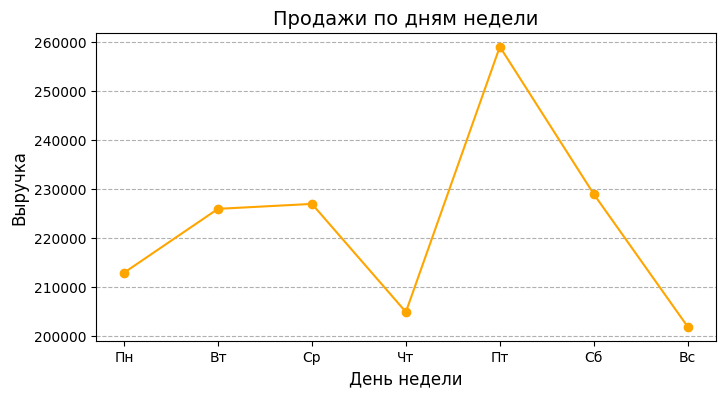

In [ ]:
weekday_revenue = data.groupby('day')['revenue'].sum().reset_index()
plt.figure(figsize=(8, 4))
plt.plot(weekday_revenue['day'], weekday_revenue['revenue'], marker='o', color='orange')
plt.title('Продажи по дням недели', fontsize=14)
plt.xlabel('День недели', fontsize=12)
plt.ylabel('Выручка', fontsize=12)
plt.xticks(range(1, 8), labels=['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс'])
plt.grid(axis='y', linestyle='--')
plt.show()

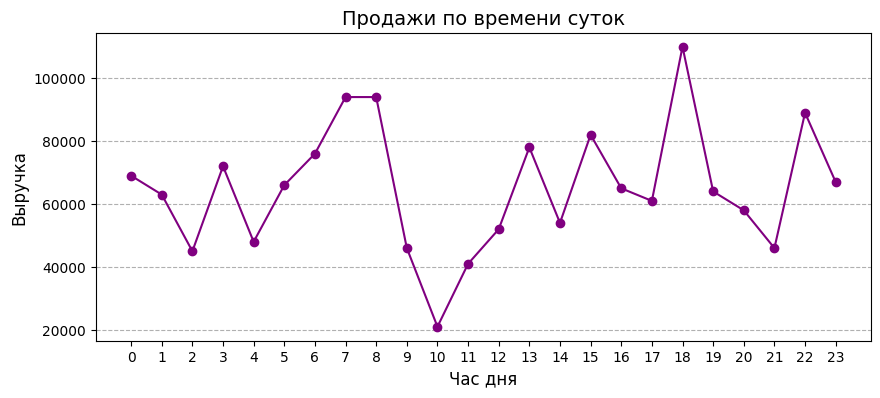

In [ ]:
hourly_revenue = data.groupby('hour_of_day')['revenue'].sum().reset_index()
plt.figure(figsize=(10, 4))
plt.plot(hourly_revenue['hour_of_day'], hourly_revenue['revenue'], marker='o', color='purple')
plt.title('Продажи по времени суток', fontsize=14)
plt.xlabel('Час дня', fontsize=12)
plt.ylabel('Выручка', fontsize=12)
plt.xticks(range(0, 24))
plt.grid(axis='y', linestyle='--')
plt.show()

### Диаграмма количества покупок по типу оплаты

In [ ]:
payment_type_counts = data['payment_type'].value_counts().reset_index()
print(payment_type_counts)

      payment_type  count
0  Mobile payments     85
1         E-wallet     66
2             Cash     60
3       Debit card     36
4      Credit card     34


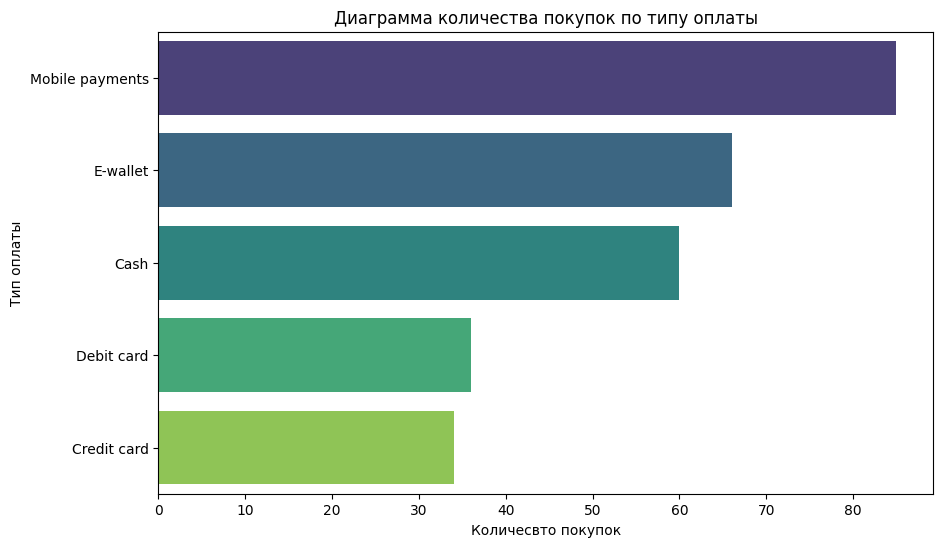

In [ ]:
plt.figure(figsize=(10, 6))
sns.barplot(data=payment_type_counts, y='payment_type', x='count', hue='payment_type', palette='viridis')
plt.title('Диаграмма количества покупок по типу оплаты')
plt.xlabel('Количесвто покупок')
plt.ylabel('Тип оплаты')
plt.show()

# Проведение расчётов

### Рассчитать средний чек.

In [ ]:
avg_receipt = data['total_revenue'].mean()
print(f"Средний чек: {avg_receipt:.2f}")

Средний чек: 1504.49


### Сколько покупок в среднем совершает 1 пользователь?

In [ ]:
payer_count = data.groupby('user_id')['payer'].sum().reset_index()
print("Среднее количество покупок одного пользователя:",round(payer_count['payer'].mean(), 5))

Среднее количество покупок одного пользователя: 0.28185


### Рассчитать среднюю продолжительность сессии по рекламным каналам.

In [ ]:
avg_sessiondur_by_channel = data.groupby('channel')['sessiondurationsec'].mean().reset_index()
avg_sessiondur_by_channel['sessiondurationsec'] = avg_sessiondur_by_channel['sessiondurationsec'].apply(lambda x: round(x, 2))
print(avg_sessiondur_by_channel)

               channel  sessiondurationsec
0       email-рассылки             1982.12
1              organic             1873.38
2  контекстная реклама             1960.79
3   реклама у блогеров             1861.45
4      социальные сети             1694.59


### Рассчитать среднюю продолжительность сессии по типу устройства.

In [ ]:
avg_sessiondur_by_device = data.groupby('device')['sessiondurationsec'].mean().reset_index()
avg_sessiondur_by_device['sessiondurationsec'] = avg_sessiondur_by_device['sessiondurationsec'].apply(lambda x: round(x, 2))
print(avg_sessiondur_by_device)

    device  sessiondurationsec
0  Android             1914.04
1      Mac             1773.43
2       PC             1934.10
3   iPhone             1724.90


### Определить топ-3 рекламных канала по среднему чеку.

In [ ]:
avg_total_revenue_by_channel = (
    data.groupby('channel')['total_revenue']
    .mean()
    .round(2)
    .reset_index()
    .sort_values('total_revenue', ascending=False)
)
avg_total_revenue_by_channel = avg_total_revenue_by_channel.reset_index(drop=True)
avg_total_revenue_by_channel.index = avg_total_revenue_by_channel.index + 1
avg_total_revenue_by_channel.head(3)

,channel,total_revenue
1,социальные сети,1651.85
2,реклама у блогеров,1547.24
3,email-рассылки,1520.55


### Определить топ-3 региона по среднему чеку.

In [ ]:
avg_total_revenue_by_channel = (
    data.groupby('region')['total_revenue']
    .mean()
    .round(2)
    .reset_index()
    .sort_values('total_revenue', ascending=False)
)
avg_total_revenue_by_channel = avg_total_revenue_by_channel.reset_index(drop=True)
avg_total_revenue_by_channel.index = avg_total_revenue_by_channel.index + 1
avg_total_revenue_by_channel.head(3)

,region,total_revenue
1,UK,1596.30
2,United States,1552.06
3,France,1296.87


### Определить топ-3 месяца по среднему чеку с разбивкой по регионам.

In [ ]:
avg_total_revenue_by_month_region = (
    data.groupby(['region', 'month'])['total_revenue']
    .mean()
    .round(2)
    .reset_index()
)

top_3_months_by_region = (
    avg_total_revenue_by_month_region
    .sort_values(['region', 'total_revenue'], ascending=[True, False])
    .groupby('region')
    .head(3)
    .reset_index(drop=True)
)

top3_channels = top_3_months_by_region.set_index(['region', 'month'])
print(top3_channels)

                     total_revenue
region        month               
France        6            2264.30
              10           1549.71
              5            1229.19
Germany       8            2244.57
              6            1352.15
              5            1166.43
UK            8            2240.34
              6            1941.75
              10           1926.96
United States 8            2133.23
              7            1755.01
              6            1688.36


### Посчитать MAU по каждому месяцу с разбивкой по рекламным каналам и выделить топ-3 рекламных каналов по количеству уникальных пользователей в месяц

In [ ]:
mau_by_channel = (
    data.groupby(['month', 'channel'])['user_id']
    .nunique()
    .reset_index(name='mau')
)

top3_channels = (
    mau_by_channel
    .sort_values(['month', 'mau'], ascending=[True, False])
    .groupby('month')
    .head(3)
)

top3_channels = top3_channels.set_index(['month', 'channel'])

print(top3_channels)

                           mau
month channel                 
5     organic               76
      социальные сети       41
      реклама у блогеров    14
6     organic               59
      социальные сети       53
      контекстная реклама   28
7     социальные сети       57
      organic               46
      контекстная реклама   24
8     социальные сети       68
      organic               61
      контекстная реклама   37
9     социальные сети       67
      organic               58
      контекстная реклама   38
10    социальные сети       85
      organic               47
      контекстная реклама   27


### Составить таблицу в которой будет указано по рекламным каналам: количество пользователей, количество уникальных пользователей, количество платящих пользователей, сумма продаж и определить какой источник “принес” больше всего платящих пользователей и большую сумму продаж.

In [ ]:
channels_info = data.groupby('channel').agg(
    total_users=('user_id', 'count'),
    unique_users=('user_id', 'nunique'),
    paying_users=('payer', 'sum'),
    total_sales=('total_revenue', 'sum')
).reset_index()

max_payers = channels_info.loc[channels_info['paying_users'].idxmax()].values[0]
max_sales = channels_info.loc[channels_info['total_sales'].idxmax()].values[0]

print(channels_info)
print('\nКанал с максимальным количеством платящих пользователей -', max_payers)
print('Канал с максимальной суммой продаж -', max_sales)

               channel  total_users  unique_users  paying_users  total_sales
0       email-рассылки           24            23             7      36493.3
1              organic          347           346            88     475814.8
2  контекстная реклама          162           159            45     230156.6
3   реклама у блогеров          101           100            29     156271.3
4      социальные сети          374           369           112     617790.9

Канал с максимальным количеством платящих пользователей - социальные сети
Канал с максимальной суммой продаж - социальные сети


# Проверка гипотез

In [ ]:
from scipy.stats import mannwhitneyu, ttest_ind, shapiro, spearmanr, kruskal, f_oneway
import warnings
warnings.filterwarnings('ignore')

### Тест на нормальность

In [ ]:
def check_normality(data):
    normality_results = {}
    for group, values in data.items():
        if len(values) >= 3:
            stat, p_value = shapiro(values)
            normality_results[group] = p_value
        else:
            normality_results[group] = None
    return normality_results

### Влияет ли тип устройства на количество покупок в день по каждому региону?

    H₀ (нулевая гипотеза): Количество покупок в день не зависит от типа устройства в регионе
    H₁ (альтернативная гипотеза): Количество покупок в день зависит от типа устройства в регионе

Тип устройства (device) - номинальная шкала
Количество покупок в день по каждому региону - количественная шкала
Используем либо ANOVA, либо критерий Краскела-Уоллиса

Проверяем на нормальность

In [ ]:
grouped1 = (data.groupby(['region', 'device', 'session_date'])
    .agg({'user_id': 'count'})
    .rename(columns={'user_id': 'sessions'})
    .reset_index()
)
data_by_region_device = {}
for (region, device), group in grouped1.groupby(['region', 'device']):
    data_by_region_device[(region, device)] = group['sessions']

print("Результаты проверки нормальности (p-value):")
normality_results = check_normality(data_by_region_device)

for group, p_value in normality_results.items():
    region, device = group
    print(f"Регион {region}, канал {device}: p-value = {p_value:.4f}")

Результаты проверки нормальности (p-value):
Регион France, канал Android: p-value = 0.0000
Регион France, канал Mac: p-value = 1.0000
Регион France, канал PC: p-value = 0.0000
Регион France, канал iPhone: p-value = 0.0000
Регион Germany, канал Android: p-value = 0.0000
Регион Germany, канал Mac: p-value = 1.0000
Регион Germany, канал PC: p-value = 0.0000
Регион Germany, канал iPhone: p-value = 0.0000
Регион UK, канал Android: p-value = 0.0000
Регион UK, канал Mac: p-value = 1.0000
Регион UK, канал PC: p-value = 0.0000
Регион UK, канал iPhone: p-value = 0.0000
Регион United States, канал Android: p-value = 0.0000
Регион United States, канал Mac: p-value = 0.0000
Регион United States, канал PC: p-value = 0.0000
Регион United States, канал iPhone: p-value = 0.0000


Дата - ненормальная, тогда используем критерий Краскела-Уоллиса

In [ ]:
def test_device_effect_on_purchases(df):
    print("Результаты проверки гипотез:")
    for region in df['region'].unique():
        region_data = grouped1[grouped1['region'] == region]

        device_groups = [
            region_data[region_data['device'] == device]['sessions']
            for device in region_data['device'].unique()
        ]

        stat, p_value = kruskal(*device_groups)
        print(f"Регион {region}: p-value = {p_value:.4f}")


test_device_effect_on_purchases(data)

Результаты проверки гипотез:
Регион United States: p-value = 0.0000
Регион France: p-value = 0.8625
Регион Germany: p-value = 0.2218
Регион UK: p-value = 0.1921


1. Регион United States: p-value = 0.0000

    Решение: Мы отвергаем H₀, так как p-value ≤ 0.05.
    Вывод: В регионе United States количество покупок в день зависит от типа устройства.

2. Регион France: p-value = 0.8625

    Решение: Мы не отвергаем H₀, так как p-value > 0.05.
    Вывод: В регионе France количество покупок в день не зависит от типа устройства.

3. Регион Germany: p-value = 0.2218

    Решение: Мы не отвергаем H₀, так как p-value > 0.05.
    Вывод: В регионе Germany количество покупок в день не зависит от типа устройства.

4. Регион UK: p-value = 0.1921

    Решение: Мы не отвергаем H₀, так как p-value > 0.05.
    Вывод: В регионе UK количество покупок в день не зависит от типа устройства.

### Влияет ли тип рекламного канала на количество покупок в день по каждому региону?

    H₀ (нулевая гипотеза): Количество покупок в день не зависит от типа рекламного канала в каждом регионе
    H₁ (альтернативная гипотеза): Количество покупок в день зависит от типа рекламного канала в каждом регионе

Тип рекламного канала (channel) - номинальная шкала
Количество покупок в день по каждому региону - количественная шкала
Используем либо ANOVA, либо критерий Краскела-Уоллиса

Проверяем на нормальность

In [ ]:
grouped2 = (
    data.groupby(['region', 'channel', 'session_date'])
    .agg({'user_id': 'count'})
    .rename(columns={'user_id': 'sessions'})
    .reset_index()
)

data_by_region_channel = {}
for (region, channel), group in grouped2.groupby(['region', 'channel']):
    data_by_region_channel[(region, channel)] = group['sessions']

print("Результаты проверки нормальности (p-value):")
normality_results = check_normality(data_by_region_channel)

for group, p_value in normality_results.items():
    region, channel = group
    print(f"Регион {region}, канал {channel}: p-value = {p_value:.4f}")


Результаты проверки нормальности (p-value):
Регион France, канал email-рассылки: p-value = 0.0000
Регион France, канал organic: p-value = 0.0000
Регион France, канал контекстная реклама: p-value = 0.0000
Регион France, канал реклама у блогеров: p-value = 0.0000
Регион Germany, канал email-рассылки: p-value = 1.0000
Регион Germany, канал organic: p-value = 0.0000
Регион Germany, канал контекстная реклама: p-value = 0.0000
Регион Germany, канал реклама у блогеров: p-value = 1.0000
Регион UK, канал email-рассылки: p-value = 1.0000
Регион UK, канал organic: p-value = 0.0000
Регион UK, канал контекстная реклама: p-value = 0.0000
Регион UK, канал реклама у блогеров: p-value = 0.0000
Регион United States, канал organic: p-value = 0.0000
Регион United States, канал контекстная реклама: p-value = 0.0000
Регион United States, канал реклама у блогеров: p-value = 0.0000
Регион United States, канал социальные сети: p-value = 0.0000


Дата - ненормальная, тогда используем критерий Краскела-Уоллиса

In [ ]:
def test_channel_effect_on_purchases(df):
    print("Результаты проверки гипотез:")
    for region in df['region'].unique():
        region_data = grouped2[grouped2['region'] == region]

        channel_groups = [
            region_data[region_data['channel'] == channel]['sessions']
            for channel in region_data['channel'].unique()
        ]

        stat, p_value = kruskal(*channel_groups)
        print(f"Регион {region}: p-value = {p_value:.4f}")


test_channel_effect_on_purchases(data)

Результаты проверки гипотез:
Регион United States: p-value = 0.0000
Регион France: p-value = 0.5260
Регион Germany: p-value = 0.2164
Регион UK: p-value = 0.1721


1. Регион United States: p-value = 0.0000

    Решение: Мы отвергаем H₀, так как p-value ≤ 0.05.
    Вывод: В регионе United States количество покупок в день зависит от типа рекламного канала.

2. Регион France: p-value = 0.5260

    Решение: Мы не отвергаем H₀, так как p-value > 0.05.
    Вывод: В регионе France количество покупок в день не зависит от типа рекламного канала.

3. Регион Germany: p-value = 0.2164

    Решение: Мы не отвергаем H₀, так как p-value > 0.05.
    Вывод: В регионе Germany количество покупок в день не зависит от типа рекламного канала.

4. Регион UK: p-value = 0.1721

    Решение: Мы не отвергаем H₀, так как p-value > 0.05.
    Вывод: В регионе UK количество покупок в день не зависит от типа рекламного канала.

### Есть ли взаимосвязь между продолжительностью сессии с суммой покупок?

    H₀ (нулевая гипотеза): Сумма покупок не зависит от продолжительностью сессии
    H₁ (альтернативная гипотеза): Сумма покупок зависит от продолжительностью сессии

Продолжительность сессии (sessiondurationsec) - количественная шкала
Сумма покупок (revenue) - количественная шкала
Используем либо корреляцию Пирсона, либо корреляцию Спирмена

Проверяем на нормальность

In [ ]:
normality = {'sessiondurationsec': data['sessiondurationsec'], 'revenue': data['revenue']}

print("Результаты проверки нормальности (p-value):")
normality_results = check_normality(normality)

for group, p_value in normality_results.items():
    print(f"Столбец {group}: p-value = {p_value:.4f}")

Результаты проверки нормальности (p-value):
Столбец sessiondurationsec: p-value = 0.0000
Столбец revenue: p-value = 0.0000


Дата - ненормальная, тогда используем корреляцию Спирмена

In [ ]:
stat, p_value = spearmanr(data['sessiondurationsec'], data['revenue'])
print(f"Статистическая значимость: {stat:.4f}, p-value: {p_value:.4f}")
if p_value < 0.05:
    print("Вывод: Есть статистически значимая взаимосвязь между продолжительностью сессии с суммой покупок")
else:
    print("Вывод: Нет статистически значимой взаимосвязь между продолжительностью сессии с суммой покупок")

# plot = data.boxplot(column='revenue', by='region', figsize=(10,6))

Статистическая значимость: 0.0301, p-value: 0.3394
Вывод: Нет статистически значимой взаимосвязь между продолжительностью сессии с суммой покупок


    Решение: Мы не отвергаем H₀, так как p-value > 0.05.
    Вывод: Сумма покупок не зависит от продолжительностью сессии

### Проверить гипотезу о том, что средний чек отличается в зависимости от региона?

    H₀ (нулевая гипотеза): Средний чек не зависит от региона
    H₁ (альтернативная гипотеза): Средний чек зависит от региона

Регион (region) - номинальная шкала
Средний чек (revenue) - количественная шкала
Используем либо ANOVA, либо критерий Краскела-Уоллиса

Проверяем на нормальность

In [ ]:
grouped3 = data.groupby('region')['revenue']
normality = {x: group for x, group in grouped3}

print("Результаты проверки нормальности (p-value):")
normality_results = check_normality(normality)

for region, p_value in normality_results.items():
    print(f"Регион {region}: p-value = {p_value:.4f}")

Результаты проверки нормальности (p-value):
Регион France: p-value = 0.0000
Регион Germany: p-value = 0.0000
Регион UK: p-value = 0.0000
Регион United States: p-value = 0.0000


Дата - ненормальная, тогда используем критерий Краскела-Уоллиса

In [ ]:
groups = [group for x, group in grouped3]

stat, p_value = kruskal(*groups)

print(f"Статистическая значимость: {stat:.4f}, p-значение: {p_value:.4f}")

if p_value < 0.05:
    print("Вывод: Средний чек статистически значимо отличается в зависимости от региона.")
else:
    print("Вывод: Нет статистически значимых различий среднего чека в зависимости от региона.")

Статистическая значимость: 1.2801, p-значение: 0.7339
Вывод: Нет статистически значимых различий среднего чека в зависимости от региона.


    Решение: Мы не отвергаем H₀, так как p-value > 0.05.
    Вывод: Средний чек не зависит от региона

### Проверить гипотезу о том, что средний чек отличается в зависимости от рекламного канала?

    H₀ (нулевая гипотеза): Средний чек не зависит от рекламного канала
    H₁ (альтернативная гипотеза): Средний чек зависит от рекламного канала

Рекламный канал (channel) - номинальная шкала
Средний чек (revenue) - количественная шкала
Используем либо ANOVA, либо критерий Краскела-Уоллиса

Проверяем на нормальность

In [ ]:
channel_revenue = data.groupby('channel')['revenue']
channels = data['channel'].unique()
normality = {channel: data[data['channel'] == channel]['revenue'] for channel in channels}

print("Результаты проверки нормальности (p-value):")
normality_results = check_normality(normality)

for channel, p_value in normality_results.items():
    print(f"Рекламный канал {channel}: p-value = {p_value:.4f}")

Результаты проверки нормальности (p-value):
Рекламный канал социальные сети: p-value = 0.0000
Рекламный канал organic: p-value = 0.0000
Рекламный канал реклама у блогеров: p-value = 0.0000
Рекламный канал контекстная реклама: p-value = 0.0000
Рекламный канал email-рассылки: p-value = 0.0000


Дата - ненормальная, тогда используем критерий Краскела-Уоллиса

In [ ]:
channel_revenue_data = [data[data['channel'] == channel]['revenue'] for channel in channels]
stat, p_value = kruskal(*channel_revenue_data)

print(f"Статистическая значимость: {stat:.4f}, p-значение: {p_value:.4f}")

if p_value < 0.05:
    print("Вывод: Средний чек статистически значимо отличается в зависимости от региона.")
else:
    print("Вывод: Нет статистически значимых различий среднего чека в зависимости от канала.")


Статистическая значимость: 2.0590, p-значение: 0.7249
Вывод: Нет статистически значимых различий среднего чека в зависимости от канала.


    Решение: Мы не отвергаем H₀, так как p-value > 0.05.
    Вывод: Средний чек не зависит от рекламного канала

### Проверить гипотезу о том, что средний чек отличается в зависимости от времени суток?

    H₀ (нулевая гипотеза): Средний чек не зависит от времени суток
    H₁ (альтернативная гипотеза): Средний чек зависит от времени суток

Время суток (time_of_day) - номинальная шкала
Средний чек (revenue) - количественная шкала
Используем либо ANOVA, либо критерий Краскела-Уоллиса

Проверяем на нормальность

In [ ]:
data_by_time = {}
for time_of_day, group in data.groupby('time_of_day'):
    data_by_time[time_of_day] = group['revenue']

print("Результаты проверки нормальности (p-value):")
normality_results = check_normality(data_by_time)

for time_of_day, p_value in normality_results.items():
    print(f"Время суток: {time_of_day}, p-value = {p_value:.4f}")

Результаты проверки нормальности (p-value):
Время суток: вечер, p-value = 0.0000
Время суток: день, p-value = 0.0000
Время суток: ночь, p-value = 0.0000
Время суток: утро, p-value = 0.0000


Дата - ненормальная, тогда используем критерий Краскела-Уоллиса

In [ ]:
def test_time_of_day_total_revenue(df):
    print("Результаты проверки гипотезы:")
    groups = [group['revenue'] for x, group in df.groupby('time_of_day')]

    stat, p_value = kruskal(*groups)
    print(f"Краскел-Уоллис: p-value = {p_value:.4f}")


test_time_of_day_total_revenue(data)

Результаты проверки гипотезы:
Краскел-Уоллис: p-value = 0.7545


Решение: Мы не отвергаем H₀, так как p-value > 0.05.
Вывод: Средний чек не зависит от времени суток.

### Влияет ли тип рекламного канала на сумму покупок по каждому региону?

    H₀ (нулевая гипотеза): Сумма покупок не зависит от типа рекламного канала в регионе
    H₁ (альтернативная гипотеза): Сумма покупок зависит от типа рекламного канала в регионе

Тип рекламного канала (channel) - номинальная шкала
Сумма покупок по каждому региону - количественная шкала
Используем либо ANOVA, либо критерий Краскела-Уоллиса

Проверяем на нормальность

In [ ]:
data_by_region_channel = {}
for (region, channel), group in data.groupby(['region', 'channel']):
    data_by_region_channel[(region, channel)] = group['revenue']

print("Результаты проверки нормальности (p-value):")
normality_results = check_normality(data_by_region_channel)
for (region, channel), p_value in normality_results.items():
    print(f"Регион {region}, канал {channel}: p-value = {p_value:.4f}")

Результаты проверки нормальности (p-value):
Регион France, канал email-рассылки: p-value = 0.0002
Регион France, канал organic: p-value = 0.0000
Регион France, канал контекстная реклама: p-value = 0.0000
Регион France, канал реклама у блогеров: p-value = 0.0000
Регион Germany, канал email-рассылки: p-value = 0.0001
Регион Germany, канал organic: p-value = 0.0000
Регион Germany, канал контекстная реклама: p-value = 0.0000
Регион Germany, канал реклама у блогеров: p-value = 0.0000
Регион UK, канал email-рассылки: p-value = 0.0003
Регион UK, канал organic: p-value = 0.0000
Регион UK, канал контекстная реклама: p-value = 0.0000
Регион UK, канал реклама у блогеров: p-value = 0.0000
Регион United States, канал organic: p-value = 0.0000
Регион United States, канал контекстная реклама: p-value = 0.0000
Регион United States, канал реклама у блогеров: p-value = 0.0000
Регион United States, канал социальные сети: p-value = 0.0000


Дата - ненормальная, тогда используем критерий Краскела-Уоллиса

In [ ]:
def test_channel_effect_on_total_revenue(df):
    regions = df['region'].unique()
    channels = df['channel'].unique()
    print("Результаты проверки гипотез:")
    for region in regions:
        region_data = df[df['region'] == region]
        channel_groups = [region_data[region_data['channel'] == channel]['revenue'] for channel in region_data['channel'].unique()]

        stat, p_value = kruskal(*channel_groups)
        print(f"Регион {region}: p-value = {p_value:.4f}")


test_channel_effect_on_total_revenue(data)

Результаты проверки гипотез:
Регион United States: p-value = 0.8035
Регион France: p-value = 0.1662
Регион Germany: p-value = 0.8702
Регион UK: p-value = 0.9523


1. Регион United States: p-value = 0.8035

    Решение: Мы не отвергаем H₀, так как p-value > 0.05.
    Вывод: В регионе United States сумма покупок в день не зависит от типа канала.

2. Регион France: p-value = 0.1662

    Решение: Мы не отвергаем H₀, так как p-value > 0.05.
    Вывод: В регионе France сумма покупок в день не зависит от типа канала.

3. Регион Germany: p-value = 0.8702

    Решение: Мы не отвергаем H₀, так как p-value > 0.05.
    Вывод: В регионе Germany сумма покупок в день не зависит от типа канала.

4. Регион UK: p-value = 0.9523

    Решение: Мы не отвергаем H₀, так как p-value > 0.05.
    Вывод: В регионе UK сумма покупок в день не зависит от типа канала.

### Влияет ли тип устройства на сумму покупок по каждому региону?

    H₀ (нулевая гипотеза): Сумма покупок не зависит от типа устройства в регионе
    H₁ (альтернативная гипотеза): Сумма покупок зависит от типа устройства в регионе

Тип устройства (device) - номинальная шкала
Сумма покупок по каждому региону - количественная шкала
Используем либо ANOVA, либо критерий Краскела-Уоллиса

Проверяем на нормальность

In [ ]:
data_by_region_device = {}
for (region, device), group in data.groupby(['region', 'device']):
    data_by_region_device[(region, device)] = group['revenue']

print("Результаты проверки нормальности (p-value):")
normality_results = check_normality(data_by_region_device)
for (region, device), p_value in normality_results.items():
    print(f"Регион {region}, канал {device}: p-value = {p_value:.4f}")

Результаты проверки нормальности (p-value):
Регион France, канал Android: p-value = 0.0000
Регион France, канал Mac: p-value = 0.0002
Регион France, канал PC: p-value = 0.0000
Регион France, канал iPhone: p-value = 0.0000
Регион Germany, канал Android: p-value = 0.0000
Регион Germany, канал Mac: p-value = 0.0000
Регион Germany, канал PC: p-value = 0.0000
Регион Germany, канал iPhone: p-value = 0.0000
Регион UK, канал Android: p-value = 0.0000
Регион UK, канал Mac: p-value = 0.0003
Регион UK, канал PC: p-value = 0.0000
Регион UK, канал iPhone: p-value = 0.0000
Регион United States, канал Android: p-value = 0.0000
Регион United States, канал Mac: p-value = 0.0000
Регион United States, канал PC: p-value = 0.0000
Регион United States, канал iPhone: p-value = 0.0000


Дата - ненормальная, тогда используем критерий Краскела-Уоллиса

In [ ]:
def test_device_effect_on_total_revenue(df):
    regions = df['region'].unique()
    devices = df['device'].unique()
    print("Результаты проверки гипотез:")
    for region in regions:
        region_data = df[df['region'] == region]
        device_groups = [region_data[region_data['device'] == device]['revenue'] for device in region_data['device'].unique()]

        stat, p_value = kruskal(*device_groups)
        print(f"Регион {region}: p-value = {p_value:.4f}")


test_device_effect_on_total_revenue(data)

Результаты проверки гипотез:
Регион United States: p-value = 0.6596
Регион France: p-value = 0.2102
Регион Germany: p-value = 0.6543
Регион UK: p-value = 0.5422


1. Регион United States: p-value = 0.6596

    Решение: Мы не отвергаем H₀, так как p-value > 0.05.
    Вывод: В регионе United States сумма покупок в день не зависит от типа устройства.

2. Регион France: p-value = 0.2102

    Решение: Мы не отвергаем H₀, так как p-value > 0.05.
    Вывод: В регионе France сумма покупок в день не зависит от типа устройства.

3. Регион Germany: p-value = 0.6543

    Решение: Мы не отвергаем H₀, так как p-value > 0.05.
    Вывод: В регионе Germany сумма покупок в день не зависит от типа устройства.

4. Регион UK: p-value = 0.5422

    Решение: Мы не отвергаем H₀, так как p-value > 0.05.
    Вывод: В регионе UK сумма покупок в день не зависит от типа устройства.

### Влияет ли тип рекламного канала на продолжительность сессии?

    H₀ (нулевая гипотеза): Продолжительность сессии не зависит от типа рекламного канала
    H₁ (альтернативная гипотеза): Продолжительность сессии зависит от типа рекламного канала

Тип рекламного канала (channel) - номинальная шкала
Продолжительность сессии - количественная шкала
Используем либо ANOVA, либо критерий Краскела-Уоллиса

Проверяем на нормальность

In [ ]:
data_by_channel = {}
for channel, group in data.groupby('channel'):
    data_by_channel[channel] = group['sessiondurationsec']

print("Результаты проверки нормальности (p-value):")
normality_results = check_normality(data_by_channel)

for channel, p_value in normality_results.items():
    print(f"Рекламный канал: {channel}, p-value = {p_value:.4f}")

Результаты проверки нормальности (p-value):
Рекламный канал: email-рассылки, p-value = 0.0012
Рекламный канал: organic, p-value = 0.0000
Рекламный канал: контекстная реклама, p-value = 0.0000
Рекламный канал: реклама у блогеров, p-value = 0.0000
Рекламный канал: социальные сети, p-value = 0.0000


Дата - ненормальная, тогда используем критерий Краскела-Уоллиса

In [ ]:
def test_channel_effect_on_duration(df):
    print("Результаты проверки гипотезы:")
    groups = [group['sessiondurationsec'] for _, group in df.groupby('channel')]

    stat, p_value = kruskal(*groups)
    print(f"Краскел-Уоллис: p-value = {p_value:.4f}")

test_channel_effect_on_duration(data)

Результаты проверки гипотезы:
Краскел-Уоллис: p-value = 0.3979


Решение: Мы не отвергаем H₀, так как p-value > 0.05.
Вывод: Продолжительность сессии не зависит от типа рекламного канала

# Регрессионное моделирование

In [ ]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.preprocessing import OneHotEncoder

### Мы решили создать модель линейной регрессии для предсказания количества покупателей и общей выручки по месяцам на следующий год

### Количество покупателей по регионам и каналам в существующих месяцах

In [ ]:
payers_data = data[data['payer'] == 1]

payers_region_month = payers_data.groupby(
    ['region', 'month']
)['user_id'].count().reset_index(name='payers_count')

pivot_region = payers_region_month.pivot(
    index='region',
    columns='month',
    values='payers_count'
).fillna(0)

print("1. Количество покупателей по регионам и месяцам:")
print(pivot_region)

payers_channel_month = payers_data.groupby(
    ['channel', 'month']
)['user_id'].count().reset_index(name='payers_count')

pivot_channel = payers_channel_month.pivot(
    index='channel',
    columns='month',
    values='payers_count'
).fillna(0)

print("\n2. Количество покупателей по каналам и месяцам:")
print(pivot_channel)


1. Количество покупателей по регионам и месяцам:
month          5   6   7   8   9   10
region                               
France          4   7   1   4   4   6
Germany         3   5   2   9   4   2
UK              2   7   5  11   2   7
United States  23  30  35  48  28  32

2. Количество покупателей по каналам и месяцам:
month                  5     6     7     8     9     10
channel                                                
email-рассылки        2.0   1.0   0.0   1.0   1.0   2.0
organic              13.0  20.0  13.0  24.0  10.0   8.0
контекстная реклама   1.0   9.0   4.0  16.0   7.0   8.0
реклама у блогеров    6.0   5.0   4.0   7.0   3.0   4.0
социальные сети      10.0  14.0  22.0  24.0  17.0  25.0


### Линейная регрессия по количеству покупателей

In [ ]:
region_data = pivot_region.reset_index().melt(id_vars='region', var_name='month', value_name='payers')
channel_data = pivot_channel.reset_index().melt(id_vars='channel', var_name='month', value_name='payers')

def predict_next_year(data, group_col, months_to_predict=range(11, 25)):
    results = {}
    metrics = []

    for group in data[group_col].unique():
        group_df = data[data[group_col] == group]
        X = group_df['month'].values.reshape(-1, 1)
        y = group_df['payers'].values

        model = LinearRegression()
        model.fit(X, y)

        y_pred = model.predict(X)
        r2 = r2_score(y, y_pred)
        mae = mean_absolute_error(y, y_pred)

        future_months = np.array(months_to_predict).reshape(-1, 1)
        future_pred = model.predict(future_months)

        results[group] = dict(zip(months_to_predict, np.round(future_pred).astype(int)))

        metrics.append({
            group_col: group,
            'r2_score': round(r2, 3),
            'mae': round(mae, 1),
        })

        metrics_df = pd.DataFrame(metrics)

    return pd.DataFrame(results), metrics_df

region_forecast, region_metrics = predict_next_year(region_data, 'region')
print("Прогноз по регионам (ноябрь 2019 - декабрь 2020):")
print(region_forecast)
print("\nR² по регионам:")
print(region_metrics.sort_values('r2_score', ascending=False))

channel_forecast, channel_metrics = predict_next_year(channel_data, 'channel')
print("\nПрогноз по каналам (ноябрь 2019 - декабрь 2020):")
print(channel_forecast)
print("\nR² по каналам:")
print(channel_metrics.sort_values('r2_score', ascending=False))

Прогноз по регионам (ноябрь 2019 - декабрь 2020):
    France  Germany  UK  United States
11       5        4   7             38
12       5        4   8             39
13       5        4   8             41
14       5        4   9             42
15       5        4   9             44
16       5        4  10             45
17       5        4  10             47
18       6        4  10             48
19       6        4  11             50
20       6        4  11             51
21       6        4  12             53
22       6        4  12             54
23       6        4  13             56
24       6        4  13             57

R² по регионам:
          region  r2_score  mae
3  United States     0.106  5.9
2             UK     0.062  2.4
0         France     0.011  1.4
1        Germany     0.000  1.9

Прогноз по каналам (ноябрь 2019 - декабрь 2020):
    email-рассылки  organic  контекстная реклама  реклама у блогеров  \
11               1       10                   12                  

### Общая выручка по регионам и каналам в существующих месяцах

In [ ]:
revenue_region_month = payers_data.groupby(
    ['region', 'month']
)['revenue'].sum().reset_index(name='payers_count')

pivot_revenue_region = revenue_region_month.pivot(
    index='region',
    columns='month',
    values='payers_count'
).fillna(0)

print("1. Общая выручка по регионам и месяцам:")
print(pivot_revenue_region)

revenue_channel_month = payers_data.groupby(
    ['channel', 'month']
)['revenue'].sum().reset_index(name='payers_count')

pivot_revenue_channel = revenue_channel_month.pivot(
    index='channel',
    columns='month',
    values='payers_count'
).fillna(0)

print("\n2. Общая выручка по каналам и месяцам:")
print(pivot_revenue_channel)


1. Общая выручка по регионам и месяцам:
month                5         6         7         8         9         10
region                                                                   
France          21996.0   38993.0    4999.0   20996.0   19996.0   31994.0
Germany         14997.0   28995.0   14998.0   46991.0   20996.0    9998.0
UK              10998.0   37993.0   25995.0   61989.0    9998.0   42993.0
United States  143977.0  169970.0  186965.0  274952.0  149972.0  168968.0

2. Общая выручка по каналам и месяцам:
month                     5         6         7         8        9         10
channel                                                                      
email-рассылки       10998.0    5999.0       0.0    4999.0   4999.0   10998.0
organic              66987.0  115980.0   72987.0  134976.0  51990.0   47992.0
контекстная реклама   4999.0   48991.0   20996.0   87984.0  34993.0   40992.0
реклама у блогеров   36994.0   25995.0   19996.0   37993.0  15997.0   20996.0
социальн

### Линейная регрессия по общей выручке

In [ ]:
region_data = pivot_revenue_region.reset_index().melt(id_vars='region', var_name='month', value_name='revenue')
channel_data = pivot_revenue_channel.reset_index().melt(id_vars='channel', var_name='month', value_name='revenue')

def predict_next_year(data, group_col, months_to_predict=range(11, 25)):
    results = {}
    metrics = []

    for group in data[group_col].unique():
        group_df = data[data[group_col] == group]
        X = group_df['month'].values.reshape(-1, 1)
        y = group_df['revenue'].values

        model = LinearRegression()
        model.fit(X, y)

        y_pred = model.predict(X)
        r2 = r2_score(y, y_pred)
        mae = mean_absolute_error(y, y_pred)

        future_months = np.array(months_to_predict).reshape(-1, 1)
        future_pred = model.predict(future_months)

        results[group] = dict(zip(months_to_predict, np.round(future_pred).astype(int)))
        metrics.append({
            group_col: group,
            'r2_score': round(r2, 3),
            'mae': round(mae, 1),
        })

        metrics_df = pd.DataFrame(metrics)

    return pd.DataFrame(results), metrics_df

region_forecast, region_metrics = predict_next_year(region_data, 'region')
print("Прогноз по регионам (ноябрь 2019 - декабрь 2020):")
print(region_forecast)
print("\nR² по регионам:")
print(region_metrics.sort_values('r2_score',ascending=False))

channel_forecast, channel_metrics = predict_next_year(channel_data, 'channel')
print("\nПрогноз по каналам (ноябрь 2019 - декабрь 2020):")
print(channel_forecast)
print("\nR² по каналам:")
print(channel_metrics.sort_values('r2_score', ascending=False))

Прогноз по регионам (ноябрь 2019 - декабрь 2020):
    France  Germany     UK  United States
11   24062    21129  42859         197762
12   24319    20644  46059         202132
13   24576    20158  49258         206502
14   24833    19672  52458         210872
15   25090    19187  55658         215242
16   25347    18701  58857         219612
17   25604    18215  62057         223982
18   25861    17729  65256         228352
19   26118    17244  68456         232722
20   26375    16758  71655         237092
21   26632    16272  74855         241462
22   26889    15787  78054         245832
23   27146    15301  81254         250201
24   27403    14815  84453         254571

R² по регионам:
          region  r2_score      mae
2             UK     0.089  14397.6
3  United States     0.029  32327.4
1        Germany     0.005   9947.3
0         France     0.002   8135.1

Прогноз по каналам (ноябрь 2019 - декабрь 2020):
    email-рассылки  organic  контекстная реклама  реклама у блогеров  \
1

Решение: Так как месяцев мало, мы не стали разбивать данные с помощью train_test_split, также итоговый r2_score является низким, что указывает на неточность предсказанных данных. Мы решили, что линейная регрессия не является фактором, влияющем на выбор в какой регион и канал вкладываться. Для более точного предсказания, требуется больше данных о выручке и количестве покупателей по месяцам.

## Вывод

### Рекламный канал социальные сети обладает большей долей продаж, и, основываясь на прогнозе, может принести большую выручку в сравнении с другими каналами

Регион United States имеет большую долю продаж и большее количество покупателей.
В регионе United States количество покупок в день зависит от типа устройства и рекламного канала.

In [ ]:
revenue_by_region_channel = data.pivot_table(index='region', columns='channel', values='revenue', aggfunc='sum', fill_value=0)
print(revenue_by_region_channel)

channel        email-рассылки   organic  контекстная реклама  \
region                                                         
France                22996.0   16997.0              62988.0   
Germany                4999.0   46992.0              51990.0   
UK                     9998.0   60991.0              87983.0   
United States             0.0  365932.0              35994.0   

channel        реклама у блогеров  социальные сети  
region                                              
France                    35993.0              0.0  
Germany                   32994.0              0.0  
UK                        30994.0              0.0  
United States             57990.0         634888.0  


In [ ]:
payers_by_region_channel = data.pivot_table(index='region', columns='channel', values='payer', aggfunc='sum', fill_value=0)
print(payers_by_region_channel)

channel        email-рассылки  organic  контекстная реклама  \
region                                                        
France                      4        3                   12   
Germany                     1        8                   10   
UK                          2        9                   17   
United States               0       68                    6   

channel        реклама у блогеров  социальные сети  
region                                              
France                          7                0  
Germany                         6                0  
UK                              6                0  
United States                  10              112  
